In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
def f(x:float,y:float):
    return x**2 + y**2 / 5.0

In [4]:
def get_numerical_gradients(func:callable, x:float,y:float, e:float=0.000000001):
    return (func(x+e, y) - func(x-e, y)) / (2*e),  (func(x, y+e) - func(x, y-e)) / (2*e)

In [5]:
iterations=100
init_x, init_y = 10,10
LR=0.01

In [6]:
def sgd_step(func:callable, x:float,y:float, lr:float=LR):
    x_grad, y_grad = get_numerical_gradients(func,x,y)
    return x - lr* x_grad, y - lr * y_grad

def momentum_step(func:callable, x:float,y:float, v_x:float, v_y:float, lr:float=LR, gamma:float=0.9, nesterov:bool=False):
    if nesterov:
        x_grad, y_grad = get_numerical_gradients(func,x-gamma*v_x,y-gamma*v_y)
    else:
        x_grad, y_grad = get_numerical_gradients(func,x,y)
    v_x = gamma * v_x  + lr * x_grad
    v_y = gamma * v_y + lr * y_grad
    x = x - v_x
    y = y - v_y
    return x, y, v_x, v_y

In [7]:
class Simulator(object):
    def __init__(self, iterations:int, init_x:float, init_y:float, func:callable, lr:float):
        self.init_x  = init_x
        self.init_y = init_y
        self.iterations = iterations
        self.func = func
        self.f_values = [self.func(self.init_x, self.init_y)]
        self.x_values = [init_x]
        self.y_values = [init_y]
        self.lr = lr
        self.x = init_x
        self.y = init_y
    def step(self):
        raise NotImplementedError
    
    def simulate(self):
        for it in range(self.iterations):
            self.step()


In [8]:
class SGDSimulator(Simulator):
    def __init__(self, iterations:int, init_x:float, init_y:float, func:callable, lr:float):
        super(SGDSimulator,self).__init__(iterations, init_x, init_y, func, lr)
    
    def step(self):
        self.x,self.y = sgd_step(self.func,self.x,self.y)
        self.x_values.append(self.x)
        self.y_values.append(self.y )
        loss = self.func(self.x,self.y)
        self.f_values.append(loss)
        

In [9]:
class MomentumSimulator(Simulator):
    def __init__(self, iterations:int, init_x:float, init_y:float, func:callable, lr, gamma:float=0.9, nesterov:bool=False):
        super(MomentumSimulator,self).__init__(iterations=iterations,init_x=init_x, init_y=init_y, func=func, lr=lr)
        self.gamma = gamma
        self.v_x = 0.0
        self.v_y = 0.0
        self.v_x_history = []
        self.v_y_history = []
        self.nesterov = nesterov
    
    
    def step(self):
        self.x,self.y, self.v_x, self.v_y = momentum_step(func=self.func,x=self.x,y=self.y, v_x=self.v_x, 
                                                          v_y=self.v_y,gamma=self.gamma, nesterov=self.nesterov)
        self.x_values.append(self.x)
        self.y_values.append(self.y )
        loss = self.func(self.x,self.y)
        self.f_values.append(loss)
        self.v_x_history.append(self.v_x)
        self.v_y_history.append(self.v_y)

In [10]:
momentum = MomentumSimulator(iterations=iterations,init_x=init_x,init_y=init_y,func=f,lr=LR)
momentum.simulate()

In [11]:
sgd = SGDSimulator(iterations=iterations,init_x=init_x,init_y=init_y,func=f,lr=LR)
sgd.simulate()

In [12]:
nesterov = MomentumSimulator(iterations=iterations,init_x=init_x,init_y=init_y,func=f,lr=LR, nesterov=True)
nesterov.simulate()

<IPython.core.display.Javascript object>


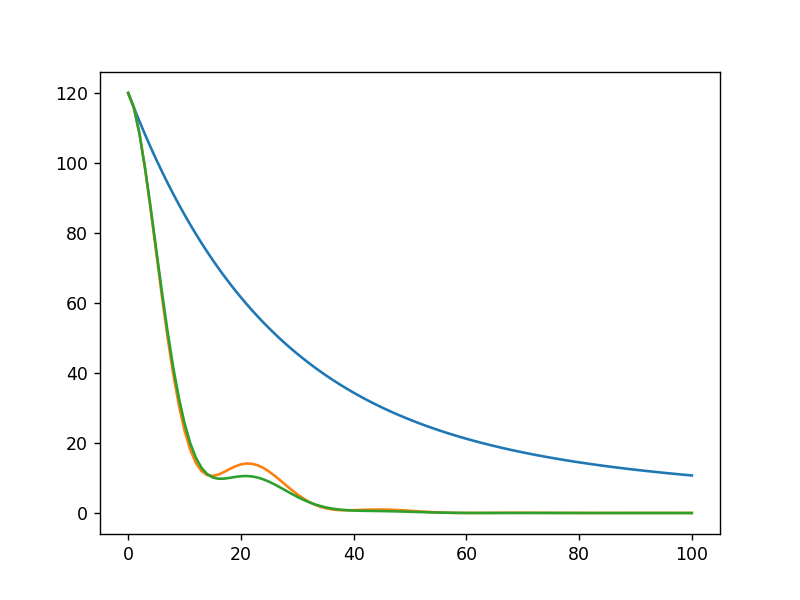

In [13]:
plt.plot(sgd.f_values, label='SGD')
plt.plot(momentum.f_values, label='Momentum')
plt.plot(nesterov.f_values, label='Nesterov')

<IPython.core.display.Javascript object>


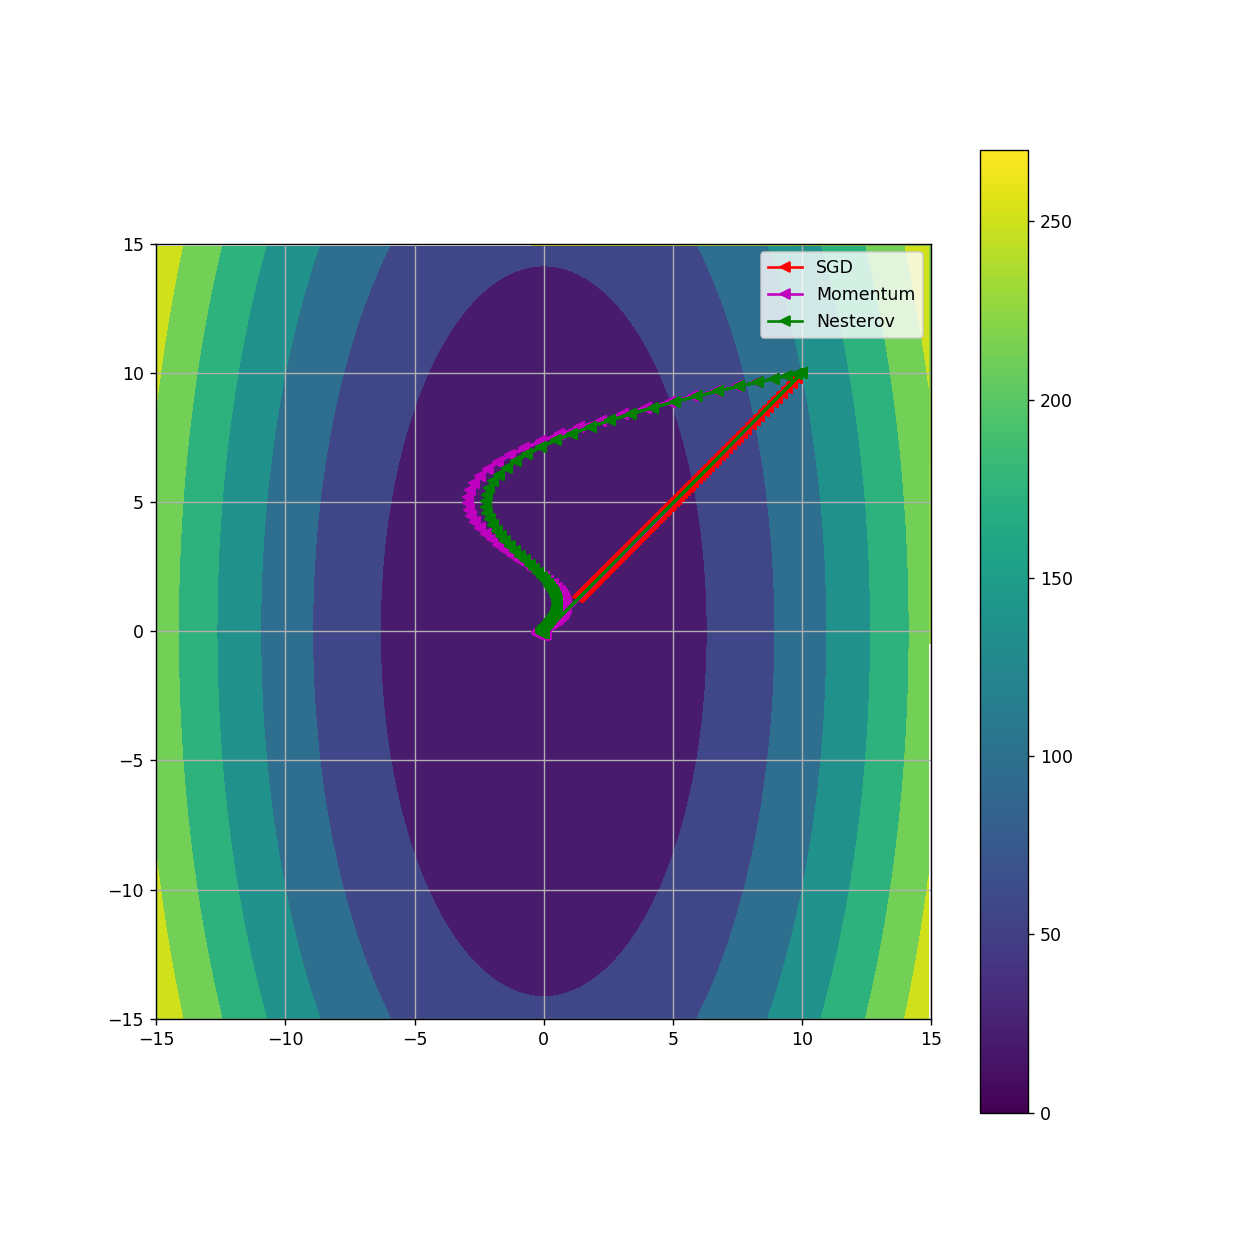

In [14]:
X,Y = np.meshgrid(np.arange(-15,15,0.1), np.arange(-15,15,0.1))
# X,Y = np.meshgrid(np.arange(-x_max,x_max,0.1), np.arange(-y_max,y_max,0.1))
Z = f(X,Y)

x_sgd_anim = []
y_sgd_anim = []
x_momentum_anim = []
y_momentum_anim = []

x_nesterov_anim = []
y_nesterov_anim = []
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
line_sgd, = ax.plot(0, 0, marker='<', label='SGD', color='r')
line_mom, = ax.plot(0, 0, marker='<', label='Momentum', color='m')
line_nesterov, = ax.plot(0, 0, marker='<', label='Nesterov', color='g')
plt.legend()
ax.contourf(X,Y, Z)

def animation_frame(step):
    x_sgd_anim.append(step[0])
    y_sgd_anim.append(step[1])
    x_momentum_anim.append(step[2])
    y_momentum_anim.append(step[3])
    x_nesterov_anim.append(step[4])
    y_nesterov_anim.append(step[5])
    line_sgd.set_xdata(x_sgd_anim)
    line_sgd.set_ydata(x_sgd_anim)
    line_mom.set_xdata(x_momentum_anim)
    line_mom.set_ydata(y_momentum_anim)
    line_nesterov.set_xdata(x_nesterov_anim)
    line_nesterov.set_ydata(y_nesterov_anim)    
    return line_sgd,line_mom, line_nesterov,

# frames = np.array([[x,y,z,w] for x,y,z,w in zip(x_sgd, y_sgd, x_mom,y_mom)] )
frames = np.array([[x1,y1,x2,y2, x3,y3] for x1,y1,x2,y2,x3,y3 in 
                   zip(sgd.x_values, sgd.y_values, momentum.x_values,momentum.y_values, nesterov.x_values,nesterov.y_values)] )
animation = FuncAnimation(fig, func=animation_frame, frames=frames, interval=100)

plt.imshow(Z)
plt.colorbar()
plt.grid()
plt.show()

